In [1]:
# import os
# os._exit(0)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
from torchvision.io import read_image
import os
import lxml.etree as ET
from PIL import Image
from torch.utils.data._utils.collate import default_collate
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

class MultiHeadAttention(nn.Module):
    def __init__(self, config, causal, cross=False):
        super().__init__()
        self.num_heads = config['n_head']
        self.head_size = config['n_embed'] // config['n_head']
        self.causal = causal
        self.cross = cross
        self.q_attn = nn.Linear(config['n_embed'], config['n_embed'], bias=False)
        self.kv_attn = nn.Linear(config['n_embed'], config['n_embed'] * 2, bias=False)
        self.c_proj = nn.Linear(config['n_embed'], config['n_embed'], bias=False)
        self.attn_dropout = nn.Dropout(config['dropout'])
        self.resid_dropout = nn.Dropout(config['dropout'])

        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')

        if not self.flash:
            self.register_buffer("tril", torch.tril(torch.ones(config['block_size'], config['block_size'])))

    def forward(self, x, y=None, mask=None):
        B, T_dec, C = x.shape

        if y is None:
            y = x

        B, T_enc, C = y.shape

        q = self.q_attn(x).view(B, T_dec, self.num_heads, self.head_size).transpose(1, 2)
        k, v = self.kv_attn(y).split(C, dim=-1)
        k = k.view(B, T_enc, self.num_heads, self.head_size).transpose(1, 2)
        v = v.view(B, T_enc, self.num_heads, self.head_size).transpose(1, 2)

        if self.flash:
            out = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, is_causal=self.causal)
        else:
            wei = q @ k.transpose(-2, -1) * 1.0 / math.sqrt(k.size(-1))
            if self.causal:
                if mask is None:
                    wei = wei.masked_fill(self.tril[:T_dec, :T_enc] == 0, float('-inf'))
                else:
                    wei = wei.masked_fill(mask == 0, float('-inf'))
            wei = F.softmax(wei, dim=-1)
            wei = self.attn_dropout(wei)
            out = wei @ v

        out = out.transpose(1, 2).contiguous().view(B, T_dec, -1)
        out = self.resid_dropout(self.c_proj(out))
        return out

class FeedFoward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config['n_embed'], 4 * config['n_embed']),
            nn.GELU(),
            nn.Linear(4 * config['n_embed'], config['n_embed']),
            nn.Dropout(config['dropout']),
        )

    def forward(self, x):
        return self.net(x)

class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa = MultiHeadAttention(config, causal=False, cross=False)
        self.ffwd = FeedFoward(config)
        self.ln1 = nn.LayerNorm(config['n_embed'])
        self.ln2 = nn.LayerNorm(config['n_embed'])

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, config, cross=True):
        super().__init__()
        self.cross = cross
        self.sa = MultiHeadAttention(config, causal=True, cross=False)
        if self.cross:
            self.cross_sa = MultiHeadAttention(config, causal=False, cross=True)
            self.ln2 = nn.LayerNorm(config['n_embed'])
        self.ffwd = FeedFoward(config)
        self.ln1 = nn.LayerNorm(config['n_embed'])
        self.ln3 = nn.LayerNorm(config['n_embed'])

    def forward(self, x, y=None):
        x = x + self.sa(self.ln1(x))
        if self.cross:
            x = x + self.cross_sa(self.ln2(x), y)
        x = x + self.ffwd(self.ln3(x))
        return x

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
dataset_path = "/kaggle/input/pascal-voc-2012/VOC2012"

# Pascal VOC class names
voc_classes = [
    'background',  # Index 0 is reserved for background
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Create a mapping from class names to indices
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(voc_classes)}

class PascalVOCDataset(Dataset):
    def __init__(self, root, transform=None, max_objects=30):
        self.root = root
        self.transform = transform
        self.image_dir = os.path.join(root, 'JPEGImages')
        self.annotation_dir = os.path.join(root, 'Annotations')
        self.image_files = os.listdir(self.image_dir)
        self.max_objects = max_objects
        self.class_to_idx = class_to_idx  # Use the class-to-index mapping

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        annotation_path = os.path.join(self.annotation_dir, img_name.replace('.jpg', '.xml'))

        # Read image with cv2
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        targets = self.parse_voc_xml(ET.parse(annotation_path).getroot())

        original_height, original_width = image.shape[:2]

        if self.transform:
            # Transform image and boxes together
            transformed = self.transform(
                image=image,
                bboxes=[obj['bbox'] for obj in targets['objects']]
            )
            
            image = transformed['image']
            transformed_boxes = transformed['bboxes']
            
            # Convert to normalized coordinates (0-1)
            resized_boxes = []
            for bbox in transformed_boxes:
                x_min, y_min, x_max, y_max = bbox
                resized_boxes.append([
                    x_min/224, y_min/224,
                    x_max/224, y_max/224
                ])
        else:
            resized_boxes = [obj['bbox'] for obj in targets['objects']]

        # Rest stays the same
        target_classes = [self.class_to_idx[obj['name']] for obj in targets['objects']][:self.max_objects]
        target_boxes = resized_boxes[:self.max_objects]

        padding_len = self.max_objects - len(target_classes)
        if padding_len > 0:
            target_classes.extend([0] * padding_len)
            target_boxes.extend([[0, 0, 0, 0]] * padding_len)

        target_classes = torch.tensor(target_classes, dtype=torch.long)
        target_boxes = torch.tensor(target_boxes, dtype=torch.float32)

        return image, {'classes': target_classes, 'boxes': target_boxes}

    def parse_voc_xml(self, node):
        targets = {}
        for child in node:
            if child.tag == 'object':
                obj = {}
                for attr in child:
                    if attr.tag == 'bndbox':
                        # Convert float coordinates to int
                        obj['bbox'] = [
                            int(float(attr.find('xmin').text)),
                            int(float(attr.find('ymin').text)),
                            int(float(attr.find('xmax').text)),
                            int(float(attr.find('ymax').text))
                        ]
                    else:
                        obj[attr.tag] = attr.text
                if 'objects' not in targets:
                    targets['objects'] = []
                targets['objects'].append(obj)
        return targets

def custom_collate_fn(batch):
    """
    Custom collate function to handle the targets dictionary.
    """
    images = []
    targets = {'classes': [], 'boxes': []}

    for img, tgt in batch:
        images.append(img)
        targets['classes'].append(tgt['classes'])
        targets['boxes'].append(tgt['boxes'])

    # Stack images and targets
    images = torch.stack(images, dim=0)  # (B, C, H, W)
    targets['classes'] = torch.stack(targets['classes'], dim=0)  # (B, max_objects)
    targets['boxes'] = torch.stack(targets['boxes'], dim=0)  # (B, max_objects, 4)

    return images, targets

transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[]))

# Load dataset
dataset = PascalVOCDataset(root=dataset_path, transform=transform)

In [4]:
from scipy.optimize import linear_sum_assignment

def box_cxcywh_to_xyxy(boxes):
    """
    Convert boxes from [cx, cy, w, h] format to [x1, y1, x2, y2] format.
    """
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack((x1, y1, x2, y2), dim=-1)

# def hungarian_matching(pred_logits, pred_boxes, target_classes, target_boxes, lambda_L1=5, lambda_giou=2):
#     """
#     Compute the Hungarian matching between predictions and ground truth.

#     Args:
#         pred_logits: (B, num_queries, num_classes) tensor of classification logits.
#         pred_boxes: (B, num_queries, 4) tensor of predicted bounding boxes.
#         target_classes: (B, num_objects) tensor of target classes.
#         target_boxes: (B, num_objects, 4) tensor of target bounding boxes.

#     Returns:
#         indices: List of tuples where each tuple (row_ind, col_ind) represents the indices of matched predictions and targets.
#     """
#     pred_logits_d = pred_logits.detach().clone()
#     pred_boxes_d = pred_boxes.detach().clone()

#     B, num_queries = pred_logits_d.shape[:2]
#     indices = []

#     for i in range(B):
#         # No more filtering of target objects based on class 0
#         valid_classes = target_classes[i]
#         valid_boxes = target_boxes[i]

#         num_valid_objects = valid_classes.shape[0]
#         if num_valid_objects == 0:
#             indices.append(([], []))
#             continue

#         # Compute the cost matrix
#         # Classification cost (using logits, similar to original approximation)
#         cost_class = -pred_logits_d[i, :, valid_classes] # (num_queries, num_valid_objects)

#         # Bounding box cost (L1)
#         cost_bbox = torch.cdist(pred_boxes_d[i], valid_boxes, p=1)  # (num_queries, num_valid_objects)

#         # GIoU cost
#         pred_boxes_xyxy = box_cxcywh_to_xyxy(pred_boxes_d[i])
#         valid_boxes_xyxy = box_cxcywh_to_xyxy(valid_boxes)
#         cost_giou = 1 - generalized_box_iou(pred_boxes_xyxy, valid_boxes_xyxy)  # (num_queries, num_valid_objects)

#         # Total cost
#         cost = cost_class + lambda_L1 * cost_bbox + lambda_giou * cost_giou

#         # Hungarian matching
#         row_ind, col_ind = linear_sum_assignment(cost.detach().cpu())

#         indices.append((torch.as_tensor(row_ind, dtype=torch.int64), torch.as_tensor(col_ind, dtype=torch.int64)))

#     return indices

def hungarian_matching(pred_logits, pred_boxes, target_classes, target_boxes, lambda_L1=5, lambda_giou=2):
    """
    Compute the Hungarian matching between predictions and ground truth.

    Args:
        pred_logits: (B, num_queries, num_classes) tensor of classification logits.
        pred_boxes: (B, num_queries, 4) tensor of predicted bounding boxes.
        target_classes: (B, num_objects) tensor of target classes.
        target_boxes: (B, num_objects, 4) tensor of target bounding boxes.

    Returns:
        indices: List of tuples where each tuple (row_ind, col_ind) represents the indices of matched predictions and targets.
    """
    pred_logits_d = pred_logits.detach().clone()
    pred_boxes_d = pred_boxes.detach().clone()

    B, num_queries = pred_logits_d.shape[:2]
    indices = []

    for i in range(B):
        # Filter out padded objects (class 0 and boxes [0, 0, 0, 0])
        valid_indices = (target_classes[i] != 0).nonzero(as_tuple=True)[0]
        if len(valid_indices) == 0:
            indices.append(([], []))
            continue

        valid_classes = target_classes[i, valid_indices]
        valid_boxes = target_boxes[i, valid_indices]

        # cost_class calculation
        prob_pred = F.softmax(pred_logits_d[i], -1) # (num_queries, num_classes)
        cost_class = -prob_pred[:, valid_classes] # (num_queries, num_targets)

        cost_bbox = torch.cdist(pred_boxes_d[i], valid_boxes, p=1)
        pred_boxes_xyxy = box_cxcywh_to_xyxy(pred_boxes_d[i])
        valid_boxes_xyxy = box_cxcywh_to_xyxy(valid_boxes)
        cost_giou = 1 - generalized_box_iou(pred_boxes_xyxy, valid_boxes_xyxy)

        cost = cost_class + lambda_L1 * cost_bbox + lambda_giou * cost_giou

        row_ind, col_ind = linear_sum_assignment(cost.detach().cpu())
        indices.append((torch.as_tensor(row_ind, dtype=torch.int64), torch.as_tensor(col_ind, dtype=torch.int64)))

    return indices

def box_area(boxes):
    """
    Compute the area of bounding boxes.
    Args:
        boxes: (..., 4) tensor of bounding boxes (x1, y1, x2, y2).
    Returns:
        area: (...,) tensor of box areas.
    """
    return (boxes[..., 2] - boxes[..., 0]) * (boxes[..., 3] - boxes[..., 1])

def generalized_box_iou(boxes1, boxes2):
    """
    Compute the Generalized IoU between two sets of boxes.

    Args:
        boxes1: (N, 4) or (B, N, 4) tensor of bounding boxes (x1, y1, x2, y2) for predictions.
        boxes2: (M, 4) or (B, M, 4) tensor of bounding boxes (x1, y1, x2, y2) for targets.

    Returns:
        giou: (N, M) or (B, N, M) tensor of Generalized IoU values.
    """

    # Ensure boxes have the correct shape
    assert boxes1.shape[-1] == 4, f"boxes1 must have shape (N, 4) or (B, N, 4), but got {boxes1.shape}"
    assert boxes2.shape[-1] == 4, f"boxes2 must have shape (M, 4) or (B, M, 4), but got {boxes2.shape}"

    # Handle 2D and 3D cases
    if boxes1.ndim == 2:  # Single image
        boxes1 = boxes1.unsqueeze(0)  # Add a batch dimension
        boxes2 = boxes2.unsqueeze(0)  # Add a batch dimension
        squeeze_output = True
    else:
        squeeze_output = False

    B, N, _ = boxes1.shape
    _, M, _ = boxes2.shape

    # Compute box areas
    area1 = box_area(boxes1)  # (B, N)
    area2 = box_area(boxes2)  # (B, M)

    # Compute intersection (broadcasting for each image)
    lt = torch.max(boxes1[:, :, None, :2], boxes2[:, None, :, :2])  # (B, N, M, 2)
    rb = torch.min(boxes1[:, :, None, 2:], boxes2[:, None, :, 2:])  # (B, N, M, 2)
    wh = (rb - lt).clamp(min=0)  # (B, N, M, 2)
    inter = wh[..., 0] * wh[..., 1]  # (B, N, M)

    # Compute union
    union = area1[:, :, None] + area2[:, None, :] - inter  # (B, N, M)

    # Compute IoU
    iou = inter / union.clamp(min=1e-7)  # (B, N, M) Avoid division by zero

    # Compute convex hull for GIoU
    lt_min = torch.min(boxes1[:, :, None, :2], boxes2[:, None, :, :2])  # (B, N, M, 2)
    rb_max = torch.max(boxes1[:, :, None, 2:], boxes2[:, None, :, 2:])  # (B, N, M, 2)

    # Area of the convex hull
    convex_hull_area = (rb_max - lt_min).clamp(min=1e-7)  # (B, N, M, 2)
    area = convex_hull_area[..., 0] * convex_hull_area[..., 1]  # (B, N, M)

    giou = iou - (area - union) / area.clamp(min=1e-7)  # (B, N, M) Avoid division by zero

    if squeeze_output:
        return giou.squeeze(0)
    else:
        return giou

def detr_loss(pred_logits, pred_boxes, target_classes, target_boxes, lamda_L1=5, lamda_giou=2):
    """
    Compute the DETR loss with Hungarian matching.
    """
    # Hungarian matching
    indices = hungarian_matching(pred_logits, pred_boxes, target_classes, target_boxes)

    # Compute losses
    loss_class = 0
    loss_bbox = 0
    loss_giou = 0
    num_objects_total = 0

    for i, (row_ind, col_ind) in enumerate(indices):
        num_objects_total += len(row_ind)
        if len(row_ind) == 0:
            continue

        # print(pred_boxes[i, row_ind].shape, target_boxes[i, col_ind].shape)
        # print(pred_boxes[i, row_ind], target_boxes[i, col_ind])

        # Classification loss
        loss_class += F.cross_entropy(pred_logits[i, row_ind], target_classes[i][col_ind])

        # Bounding box loss
        pred_boxes_matched = pred_boxes[i, row_ind]
        target_boxes_matched = target_boxes[i, col_ind]
        loss_bbox += F.l1_loss(pred_boxes_matched, target_boxes_matched)

        # GIoU loss
        pred_boxes_matched_xyxy = box_cxcywh_to_xyxy(pred_boxes_matched)
        target_boxes_matched_xyxy = box_cxcywh_to_xyxy(target_boxes_matched)
        giou_matrix = generalized_box_iou(pred_boxes_matched_xyxy, target_boxes_matched_xyxy)
        loss_giou += (1.0 - torch.diag(giou_matrix)).mean()

    # Avoid division by zero
    if num_objects_total == 0:
        return torch.tensor(0.0, device=pred_logits.device, requires_grad=True)

    # Normalize losses
    loss_class /= num_objects_total
    loss_bbox /= num_objects_total
    loss_giou /= num_objects_total

    # Total loss
    return loss_class, loss_bbox, loss_giou

In [5]:
import torchvision.models as models

class ResNetBackbone(nn.Module):
    def __init__(self, backbone_name='resnet50', pretrained=True):
        super().__init__()
        # Load the pre-trained ResNet model
        backbone = getattr(models, backbone_name)(pretrained=pretrained)
        
        # Remove the FC layer and avgpool
        
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])
        
        # Get the number of output channels from the backbone
        self.out_channels = backbone.fc.in_features

    def forward(self, x):
        # Extract feature maps
        return self.backbone(x)  # (B, C, H/32, W/32)

class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, height, width):
        super().__init__()
        self.d_model = d_model
        self.height = height
        self.width = width

        # Create positional encodings for height and width
        pe_height = self._create_pe(d_model // 2, height)  # (height, d_model // 2)
        pe_width = self._create_pe(d_model // 2, width)  # (width, d_model // 2)

        # Combine height and width encodings
        pe_height = pe_height.unsqueeze(1).repeat(1, width, 1)  # (height, width, d_model // 2)
        pe_width = pe_width.unsqueeze(0).repeat(height, 1, 1)  # (height, width, d_model // 2)
        pe = torch.cat([pe_height, pe_width], dim=-1)  # (height, width, d_model)

        # Register as a buffer
        self.register_buffer('pe', pe.permute(2, 0, 1).unsqueeze(0))  # (1, d_model, height, width)

    def _create_pe(self, d_model, max_len):
        """Create 1D sinusoidal positional encoding."""
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, x):
        """
        Args:
            x: (B, C, H, W)
        Returns:
            x + pe: (B, C, H, W)
        """
        return x + self.pe[:, :, :x.size(2), :x.size(3)]
    
class BoundingBoxFFN(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Linear(d_model * 2, d_model * 2), 
            nn.ReLU(),
            nn.Linear(d_model * 2, 4),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

class DETR(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Backbone
        self.backbone = ResNetBackbone(backbone_name='resnet50', pretrained=True)
        
        # Transformer
        self.input_proj = nn.Conv2d(self.backbone.out_channels, config['n_embed'], kernel_size=1)
        self.positional_encoding = PositionalEncoding2D(config['n_embed'], height=7, width=7)
        
        # Encoder and Decoder layers
        self.encoder_layers = nn.ModuleList([TransformerEncoder(config) for _ in range(config['num_encoder_layers'])])
        self.decoder_layers = nn.ModuleList([TransformerDecoder(config) for _ in range(config['num_decoder_layers'])])
        
        # Learnable queries
        self.num_queries = config['num_queries']
        self.query_embed = nn.Embedding(self.num_queries, config['n_embed'])
        
        # Output projections
        self.class_linear = nn.Linear(config['n_embed'], config['num_classes'])
        self.bbox_FFN = BoundingBoxFFN(config['n_embed'])

    def forward(self, x):
        # Backbone
        feature_map = self.backbone(x)  # (B, C, H/32, W/32)
        
        # Project feature map to transformer dimension
        x = self.input_proj(feature_map)  # (B, n_embed, H/32, W/32)
        
        # Flatten spatial dimensions
        B, C, H, W = x.shape
        x = x.flatten(2).permute(0, 2, 1)  # (B, HW, C)
        
        # Encoder
        for layer in self.encoder_layers:
            pos_enc = self.positional_encoding(x.permute(0, 2, 1).view(B, C, H, W)).flatten(2).permute(0, 2, 1)  # (B, HW, C)
            x = layer(x + pos_enc)  # (B, HW, C)
        
        # Prepare queries
        query_embed = self.query_embed.weight.unsqueeze(0).repeat(B, 1, 1)  # (B, num_queries, n_embed)
        
        # Decoder
        hs = 0
        for layer in self.decoder_layers:
            hs = layer(hs + query_embed, x)  # (B, num_queries, n_embed)
        
        # Output projections
        outputs_class = self.class_linear(hs)  # (B, num_queries, num_classes)
        outputs_bbox = self.bbox_FFN(hs)       # (B, num_queries, 4)
        
        return outputs_class, outputs_bbox

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from accelerate import Accelerator, notebook_launcher
from tqdm import tqdm
import accelerate

def train_function(
    learning_rate,
    optimizer_class,
    dataloader,
    model,
    num_epochs,
    weight_decay=0.0,
    resume_path=None,
    save_path=None,
    mixed_precision=None,
    save_every_n_steps=200
):
    """
    Training function with checkpoint support and weight decay.
    Args:
        learning_rate (float): Learning rate for the optimizer
        optimizer_class (torch.optim.Optimizer): Optimizer class
        dataloader (DataLoader): Training dataloader
        model (nn.Module): Model to train
        num_epochs (int): Number of training epochs
        weight_decay (float): L2 regularization strength
        resume_path (str, optional): Path to load checkpoint from
        save_path (str, optional): Path to save checkpoints to
        save_every_n_steps (int): Save checkpoint every N steps
    Returns:
        tuple: (model, optimizer, total_steps)
    """
    # Initialize Accelerator
    accelerator = Accelerator(mixed_precision=mixed_precision)
    
    # Initialize optimizer with weight decay
    optimizer = optimizer_class(
        [
            {'params': model.backbone.parameters(), 'lr': learning_rate / 10},
            {"params": [p for n, p in model.named_parameters() if "backbone" not in n], "lr": learning_rate},
        ],
        lr=learning_rate,
        weight_decay=weight_decay
    )
    
    # Track total steps
    total_steps = 0
    start_epoch = 0

    # Resume from checkpoint if specified
    if resume_path:
        checkpoint = torch.load(resume_path)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        total_steps = checkpoint['total_steps']
        start_epoch = checkpoint['epoch']

    # Prepare for distributed training
    model, optimizer, dataloader = accelerator.prepare(
        model, optimizer, dataloader
    )
    
    # Training loop
    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss = 0.0
        
        with tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
            for batch_idx, (images, targets) in enumerate(pbar):
                # Move data to device
                images = images.to(accelerator.device)
                target_classes = targets['classes'].to(accelerator.device)
                target_boxes = targets['boxes'].to(accelerator.device)
                
                # Forward pass
                with accelerator.autocast():
                    pred_logits, pred_boxes = model(images)
                    loss_class, loss_bbox, loss_giou = detr_loss(
                        pred_logits, pred_boxes, target_classes, target_boxes
                    )
                    loss = loss_class + 5 * loss_bbox + 2 * loss_giou
                
                # Backward pass
                accelerator.backward(loss)
                optimizer.step()
                optimizer.zero_grad()
                
                # Update counters
                total_steps += 1
                total_loss += loss.item()
                
                # Update tqdm bar with loss details
                pbar.set_postfix({
                    'Loss': f"{loss.item():.4f}",
                    'Loss_cls': f"{loss_class.item():.4f}",
                    'Loss_bbox': f"{loss_bbox.item():.4f}",
                    'Loss_giou': f"{loss_giou.item():.4f}"
                })
                
                # Save checkpoint if needed
                if save_path and total_steps % save_every_n_steps == 0:
                    checkpoint = {
                        'model_state': accelerator.unwrap_model(model).state_dict(),
                        'optimizer_state': optimizer.state_dict(),
                        'total_steps': total_steps,
                        'epoch': epoch
                    }
                    accelerator.save(checkpoint, f"{save_path}_step_{total_steps}.pt")
        
        # Log epoch metrics
        avg_loss = total_loss / len(dataloader)
        accelerator.print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    if save_path:
        checkpoint = {
            'model_state': accelerator.unwrap_model(model).state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'total_steps': total_steps,
            'epoch': epoch
        }
        accelerator.save(checkpoint, f"{save_path}_step_{total_steps}.pt")

In [19]:
config = {
    'n_embed': 512,  # Transformer embedding dimension
    'n_head': 16,  # Number of attention heads
    'dropout': 0.0,  # Dropout rate
    'num_encoder_layers': 8,  # Number of encoder layers
    'num_decoder_layers': 8,  # Number of decoder layers
    'num_queries': 100,  # Number of object queries
    'num_classes': 21,  # 20 classes + background
    'height': 7,  # Height of the feature map (224 / 32 = 7)
    'width': 7  # Width of the feature map (224 / 32 = 7)
}

model = DETR(config)

# Load model
model.load_state_dict(torch.load('detr.pth', weights_only=True))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [8]:
dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=custom_collate_fn,
    persistent_workers=True,
)

In [20]:
optimizer_class = torch.optim.AdamW 
learning_rate = 1e-5
weight_decay = 1e-4
num_epochs = 200
resume_path='./_step_10958.pt'
save_path = './'
mixed_precision='fp16'
save_every_n_steps=1000

args = (learning_rate, torch.optim.AdamW, dataloader, model, num_epochs, 
        weight_decay, resume_path, save_path, mixed_precision, save_every_n_steps)
    
notebook_launcher(
    train_function,
    args,
    num_processes=torch.cuda.device_count(),
)

Launching training on 2 GPUs.


<ipython-input-18-961e1dad68d4>:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(resume_path)
<ipython-input-18-961e1dad68d4>:54: FutureWarning: You

Epoch 160/200, Loss: 1.6036

Epoch 160/200: 100%|██████████| 67/67 [02:25<00:00,  2.17s/it, Loss=1.5240, Loss_cls=1.0020, Loss_bbox=0.0373, Loss_giou=0.1678]


Epoch 161/200: 100%|██████████| 67/67 [02:21<00:00,  2.11s/it, Loss=1.4162, Loss_cls=0.8584, Loss_bbox=0.0405, Loss_giou=0.1776]


Epoch 161/200, Loss: 1.6083

Epoch 162/200:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 162/200: 100%|██████████| 67/67 [02:22<00:00,  2.12s/it, Loss=1.6970, Loss_cls=1.2298, Loss_bbox=0.0327, Loss_giou=0.1518]


Epoch 162/200, Loss: 1.6265

Epoch 162/200: 100%|██████████| 67/67 [02:22<00:00,  2.12s/it, Loss=1.8598, Loss_cls=1.3988, Loss_bbox=0.0321, Loss_giou=0.1502]


Epoch 163/200: 100%|██████████| 67/67 [02:21<00:00,  2.11s/it, Loss=1.7295, Loss_cls=1.3523, Loss_bbox=0.0260, Loss_giou=0.1235]


Epoch 163/200, Loss: 1.6278

Epoch 163/200: 100%|██████████| 67/67 [02:21<00:00,  2.11s/it, Loss=1.5458, Loss_cls=1.0585, Loss_bbox=0.0333, Loss_giou=0.1603]


Epoch 164/200: 100%|██████████| 67/67 [02:21<00:00,  2.12s/it, Loss=1.8861, Loss_cls=1.4280, Loss_bbox=0.0340, Loss_giou=0.1440]


Epoch 164/200, Loss: 1.5887


Epoch 165/200: 100%|██████████| 67/67 [02:22<00:00,  2.12s/it, Loss=1.2734, Loss_cls=0.8869, Loss_bbox=0.0276, Loss_giou=0.1242]


Epoch 165/200, Loss: 1.6241

Epoch 166/200:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 166/200: 100%|██████████| 67/67 [02:21<00:00,  2.11s/it, Loss=1.7532, Loss_cls=1.3539, Loss_bbox=0.0277, Loss_giou=0.1305]


Epoch 166/200, Loss: 1.5740

Epoch 166/200: 100%|██████████| 67/67 [02:21<00:00,  2.11s/it, Loss=1.2758, Loss_cls=0.8476, Loss_bbox=0.0299, Loss_giou=0.1394]


Epoch 167/200: 100%|██████████| 67/67 [02:20<00:00,  2.09s/it, Loss=1.3188, Loss_cls=0.8444, Loss_bbox=0.0334, Loss_giou=0.1537]

Epoch 167/200, Loss: 1.5690

Epoch 168/200: 100%|██████████| 67/67 [02:21<00:00,  2.11s/it, Loss=1.7737, Loss_cls=1.2936, Loss_bbox=0.0337, Loss_giou=0.1559]


Epoch 168/200, Loss: 1.5412

Epoch 169/200:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 169/200: 100%|██████████| 67/67 [02:21<00:00,  2.10s/it, Loss=1.8658, Loss_cls=1.4369, Loss_bbox=0.0302, Loss_giou=0.1390]


Epoch 169/200, Loss: 1.5861

Epoch 170/200:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 170/200: 100%|██████████| 67/67 [02:21<00:00,  2.12s/it, Loss=1.1617, Loss_cls=0.7136, Loss_bbox=0.0314, Loss_giou=0.1455]


Epoch 170/200, Loss: 1.5230


Epoch 172/200:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 171/200, Loss: 1.5450


Epoch 172/200: 100%|██████████| 67/67 [02:21<00:00,  2.10s/it, Loss=1.4997, Loss_cls=1.0647, Loss_bbox=0.0317, Loss_giou=0.1382]


Epoch 172/200, Loss: 1.5665


Epoch 173/200: 100%|██████████| 67/67 [02:21<00:00,  2.12s/it, Loss=1.6245, Loss_cls=1.1108, Loss_bbox=0.0358, Loss_giou=0.1673]


Epoch 173/200, Loss: 1.5413

Epoch 174/200:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 174/200: 100%|██████████| 67/67 [02:20<00:00,  2.09s/it, Loss=1.8310, Loss_cls=1.3799, Loss_bbox=0.0314, Loss_giou=0.1470]


Epoch 174/200, Loss: 1.6021


Epoch 175/200: 100%|██████████| 67/67 [02:23<00:00,  2.15s/it, Loss=1.3981, Loss_cls=0.8945, Loss_bbox=0.0355, Loss_giou=0.1629]


Epoch 175/200, Loss: 1.4876

Epoch 176/200:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 176/200: 100%|██████████| 67/67 [02:20<00:00,  2.09s/it, Loss=0.9532, Loss_cls=0.5335, Loss_bbox=0.0300, Loss_giou=0.1349]


Epoch 176/200, Loss: 1.5051

Epoch 177/200:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 177/200: 100%|██████████| 67/67 [02:21<00:00,  2.11s/it, Loss=1.7811, Loss_cls=1.3132, Loss_bbox=0.0321, Loss_giou=0.1536]


Epoch 177/200, Loss: 1.5117

Epoch 178/200:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 178/200:   7%|▋         | 5/67 [00:15<02:41,  2.60s/it, Loss=1.6321, Loss_cls=1.2379, Loss_bbox=0.0273, Loss_giou=0.1289]W0131 18:19:54.104000 31 torch/distributed/elastic/agent/server/api.py:704] Received Signals.SIGINT death signal, shutting down workers
W0131 18:19:54.111000 31 torch/distributed/elastic/multiprocessing/api.py:766] Closing process 2815 via signal SIGINT
W0131 18:19:54.113000 31 torch/distributed/elastic/multiprocessing/api.py:766] Closing process 2817 via signal SIGINT
Process Process-11:2:
Process Process-12:2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
 

SignalException: Process 31 got signal: 2

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

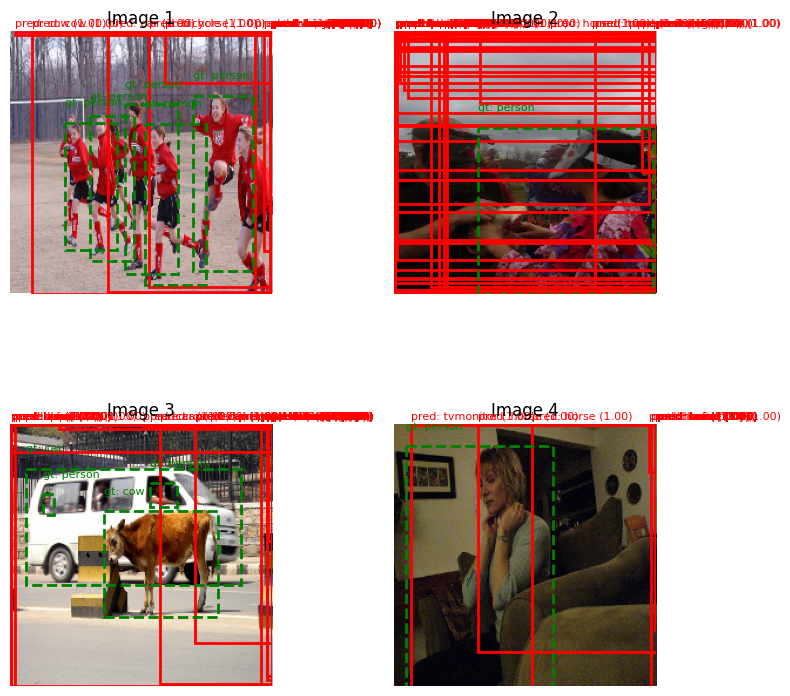

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.functional as F

dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

def plot_detections(images, pred_boxes, pred_logits, gt_boxes, gt_classes, voc_classes, num_images=4, prob_threshold=1.0-1e-4):
    """
    Plot detection results for multiple images
    Args:
        images: Tensor of images (B, C, H, W)
        pred_boxes: Predicted boxes (B, num_queries, 4)
        pred_logits: Predicted logits (B, num_queries, num_classes)
        gt_boxes: Ground truth boxes (B, max_objects, 4)
        gt_classes: Ground truth classes (B, max_objects)
        voc_classes: List of class names
        num_images: Number of images to display
        prob_threshold: Probability threshold for showing predictions
    """
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = axs.ravel()

    # Get probabilities from logits
    pred_probs = F.softmax(pred_logits, dim=-1)
    # print(pred_probs.shape)
    # print(pred_probs[0,:,0])
    pred_scores, pred_classes = pred_probs.max(dim=-1)
    # print(pred_scores.shape)
    # print(pred_scores[0])

    for idx in range(min(num_images, len(images))):
        # Get image
        image = images[idx].permute(1, 2, 0).cpu().numpy()
        image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)
        
        # Plot image
        axs[idx].imshow(image)
        
        # Plot predicted boxes
        for box, cls, score in zip(pred_boxes[idx], pred_classes[idx], pred_scores[idx]):
            if cls != 0 and score > prob_threshold:  # Skip background class and low confidence predictions
                x1, y1, x2, y2 = box
                # print(x1*224, y1*224, x2*224, y2*224)
                rect = patches.Rectangle(
                    (x1 * 224, y1 * 224), 
                    (x2 - x1) * 224, 
                    (y2 - y1) * 224, 
                    linewidth=2, 
                    edgecolor='r', 
                    facecolor='none'
                )
                axs[idx].add_patch(rect)
                axs[idx].text(
                    x1 * 224, 
                    y1 * 224 - 5, 
                    f'pred: {voc_classes[cls]} ({score:.2f})', 
                    color='red', 
                    fontsize=8
                )
        
        # Plot ground truth boxes
        for box, cls in zip(gt_boxes[idx], gt_classes[idx]):
            if cls != 0:  # Skip background class
                x1, y1, x2, y2 = box * 224
                rect = patches.Rectangle(
                    (x1, y1), 
                    ((x2 - x1)), 
                    ((y2 - y1)), 
                    linewidth=2, 
                    edgecolor='g', 
                    facecolor='none',
                    linestyle='--'
                )
                axs[idx].add_patch(rect)
                axs[idx].text(
                    x1, 
                    (y1) - 15, 
                    f'gt: {voc_classes[cls]}', 
                    color='green', 
                    fontsize=8
                )
        
        axs[idx].set_title(f'Image {idx + 1}')
        axs[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Evaluate model and visualize results
model.eval()
with torch.no_grad():
    # Get batch of images
    device = next(model.parameters()).device
    images, targets = next(iter(dataloader))
    pred_logits, pred_boxes = model(images.to(device))

    # Plot detections with probability threshold
    plot_detections(
        images, 
        pred_boxes.cpu(), 
        pred_logits.cpu(), 
        targets['boxes'], 
        targets['classes'], 
        voc_classes
    )

model.train()
print()

In [23]:
# # Save the model
# torch.save(model.state_dict(), 'detr.pth')